In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats


df = pd.read_csv('kc_house_data.csv')

My goal going into this project is to determine a few things:
1. How close can we get to determining the house price? 
2. Is there any data that violates the integrity of our model and can we remove it without negatively affecting the other categories?
3. What is the clearest way of displaying the results?

With already having a set of data to work with, my first step according to the OSEMN model of explatory data analysis (which I will be using) is to investigate the data I've been given and to scrub away any faulty information (null values, major outliers, etc...)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [148]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


When I originially loaded the data I noticed that sqft_basement was classified as an object. I assumed that the presence of a basement affects the price of a house so I decided it would be helpful to convert the column to numeric.

In [2]:
df.sqft_basement.replace("?",'0',inplace=True)

To convert the data from strings to numeric I had to first take care of the '?'s. With the unknown information making up a small portion of the data and the houses with 0 sqft_basement making up much of this data, I decided to replace all of the unknown data with a 0.

In [3]:
df.sqft_basement = df.sqft_basement.astype('float64')

The column that is next classified as an object is date. According to the data source, this column describes the date a house was sold. Because I believe that, along with 'id', this information will have no bearing on the price of a house I will go ahead and drop both columns.

In [4]:
df.drop('date',axis=1,inplace=True)

In [5]:
df.drop('id',axis=1,inplace=True)

In [15]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.321108,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.297229,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.278485,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.428660,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.015031,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,-0.241866,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,0.088213,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,0.271689,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,0.168482,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.087383,0.249727,-0.146896,1.000000,0.756073,0.165843,0.447865,0.016669,-0.185771,0.113575,0.200341,0.713867,0.120981


One of the first things I am curious about is the following: Without scrubbing any data, what is the correlation between price and the other independent variables? I am curious also with seeing any major correlation between any two variables. Some notable independent variables are: sqft_living, grade, sqft_above, sqft_living15, and bathrooms. They have a decent correlation with price. It's possible that with some additional scrubbing we can the correlation value up. It should also be noted that we are missing a couple of variables in the above table. We are missing sqft_basement and date.

According to the above info, sqft_basement and date are both dates which lets us know why we may not be seeing them displayed on the correlation table.

In [16]:
total = df.isnull().sum().sort_values(ascending=False)
total

yr_renovated     3842
waterfront       2376
view               63
sqft_lot15          0
condition           0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
grade               0
sqft_living15       0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
price               0
dtype: int64

According to the above data, there exists 3 variables with null values. I will start by scrubbing each of the variables.

In [17]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [18]:
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [6]:
df.waterfront.fillna(0,inplace=True)

The waterfront column contained 2,376 missing values. This equates to 11 percent of the possible data being a null value. Given that the data doesn't correlate too strong with any other variable, but still wanting to keep the information the rows offer, I will simply replace each null value with a 0.

In [110]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [111]:
df.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

The 'views' column has a total of 63 null values.The overwhelming amount of houses in this column contain 0 views. Because there is such a small number of null values, the model will not be too affected by the presence of this data, however, I will still convert the null values to 0 since more data is better than less. 

In [7]:
df.view.fillna(0,inplace=True)

Finally for the last column with null values which also contains the most.

In [33]:
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
2000.0       29
2005.0       29
1990.0       22
2004.0       22
2009.0       21
1989.0       20
2006.0       20
2002.0       17
1991.0       16
1998.0       16
1984.0       16
1999.0       15
2008.0       15
2010.0       15
2001.0       15
1983.0       15
2015.0       14
1985.0       14
1986.0       14
1987.0       14
1994.0       14
1992.0       13
1993.0       12
1997.0       12
1995.0       12
          ...  
1975.0        5
1964.0        5
1969.0        4
1963.0        4
1973.0        4
1981.0        4
1965.0        4
1978.0        3
1960.0        3
1958.0        3
1956.0        3
1955.0        3
1945.0        3
1972.0        3
1967.0        2
1957.0        2
1940.0        2
1974.0        2
1962.0        2
1953.0        1
1950.0        1
1934.0        1
1944.0        1
1976.0        1
1948.0        1
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Leng

In [81]:
df.yr_renovated.unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [84]:
df.yr_renovated.describe()

count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

The 'yr_renovated' column has 3,842 null values. 17,011 values in this column are 0. I don't particularly want to delete 3,842 more rows and the majority of the houses in this set of data haven't been renovated. I also see that this column has very little correlation with all other variables. With these observations being duly noted I will go ahead and replace all the null values in this column with a 0. Replacing it with the mean would make no sense since the mean of this data set is 83.

In [8]:
df.yr_renovated.fillna(0,inplace=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(10)
memory usage: 3.1 MB


The data now has no null values to worry about. My next point of interest is seeing how the remaining data relates to our dependent variable, 'price'. To do that I will be using a heatmap courtesy of seaborn.

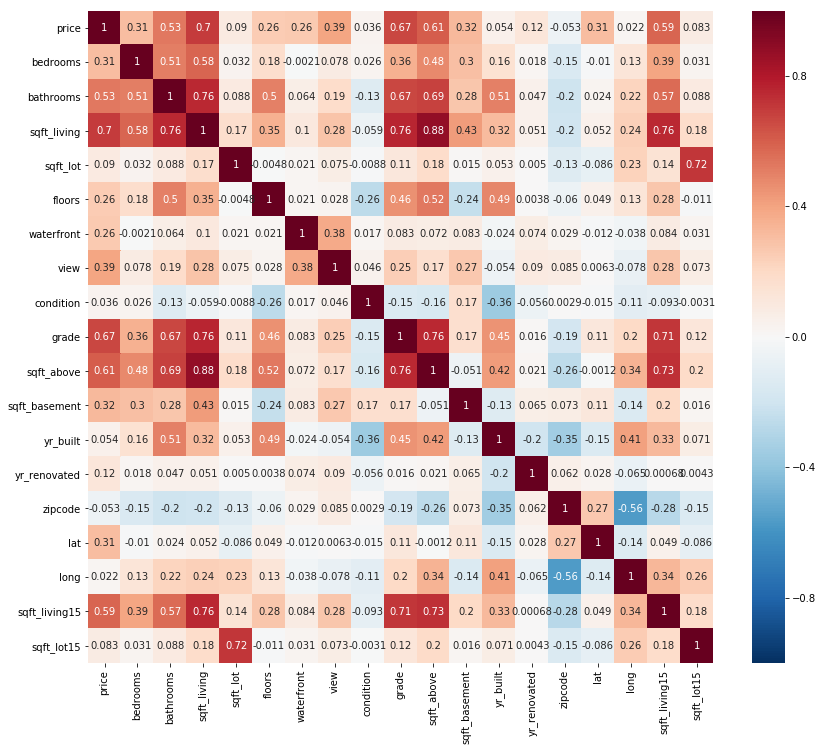

In [24]:
correlation = df.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

In [39]:
formula = 'price ~ waterfront + yr_renovated + view + bathrooms + sqft_living + sqft_living15 + grade + bedrooms + floors + condition + lat + zipcode + long + yr_built + sqft_lot + sqft_lot15'
model = ols(formula= formula, data=df).fit()

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     3136.
Date:                Mon, 27 May 2019   Prob (F-statistic):               0.00
Time:                        14:01:37   Log-Likelihood:            -2.9442e+05
No. Observations:               21597   AIC:                         5.889e+05
Df Residuals:                   21580   BIC:                         5.890e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.629e+06   2.91e+06      3.314      0.001    3.93e+06    1.53e+07
waterfront     6.224e+05   1.82e+04     34.291      0.000    5.87e+05    6.58e+05
yr_renovated     23.2264      3.982      5.832      0.000      15.421      31.032
view           5.085e+04   2097.348     24.244      0.000    4.67e+04     5.5e+04
bathrooms      3.791e+04   3227.309     11.747      0.000    3.16e+04    4.42e+04
sqft_living     169.9385      3.355     50.646      0.000     163.362     176.515
sqft_living15    25.2133      3.419      7.374      0.000      18.512      31.915
grade          9.907e+04   2141.565     46.259      0.000    9.49e+04    1.03e+05
bedrooms      -3.606e+04   1903.009    -18.948      0.000   -3.98e+04   -3.23e+04
floors         1.848e+04   3232.148      5.719      0.000    1.21e+04    2.48e+04
condition      2.539e+04   2341.559     10.844      0.000    2.08e+04       3e+04
lat            5.919e+05   1.07e+04     55.426      0.000    5.71e+05    6.13e+05
zipcode        -590.2532     33.025    -17.873      0.000    -654.985    -525.522
long          -2.014e+05    1.3e+04    -15.525      0.000   -2.27e+05   -1.76e+05
yr_built      -2644.2071     72.018    -36.716      0.000   -2785.368   -2503.046
sqft_lot          0.1398      0.048      2.915      0.004       0.046       0.234
sqft_lot15       -0.3812      0.073     -5.191      0.000      -0.525      -0.237
==============================================================================
Omnibus:                    18497.799   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1898941.006
Skew:                           3.605   Prob(JB):                         0.00
Kurtosis:                      48.368   Cond. No.                     2.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A couple of things to note from the above model summary is the following:
1. The r-squared value of our model is .699 which means that the model can explain 69.9 percent of the variation of data. I have yet to normalize the data so I am curious to see what effect that will have.
2. Just about all our of variables have a p-value of 0 which means they are significant and relevant for our model.

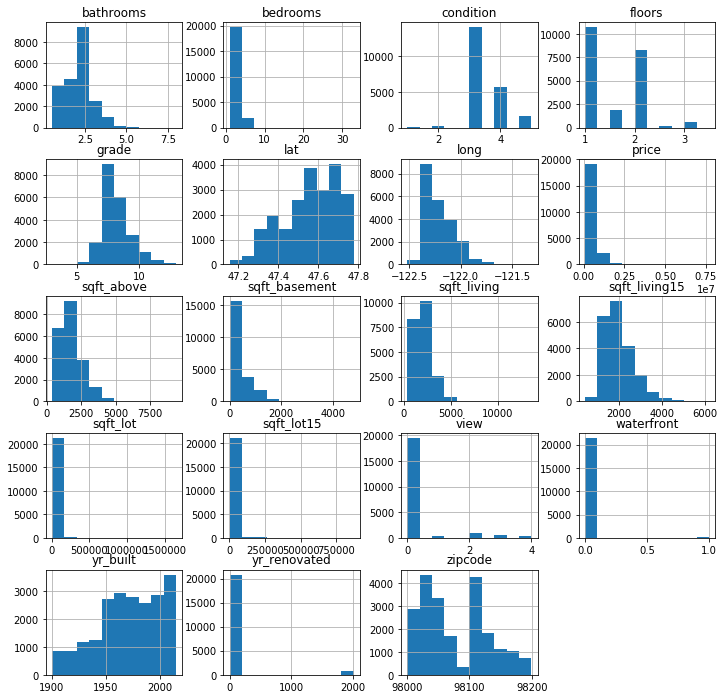

In [49]:
df.hist(figsize=[12,12]);

Much of the data does not follow a normal distriubtion so I will attempt to make the data appear more normal.

In [9]:
df2 = pd.DataFrame([])

In [10]:
df2['grade'] = df.grade
df2['baths'] = df.bathrooms
df2['beds'] = df.bedrooms
df2['cond'] = df.condition
df2['floor'] = df.floors
df2['lat'] = df.lat
df2['long'] = df.long
df2['price'] = np.log(df.price)
df2['sqft_above'] = np.log(df.sqft_above)
df2['sqft_basement'] = np.log(df.sqft_basement)
df2['sqft_living'] = np.log(df.sqft_living)
df2['sqft_living15'] = np.log(df.sqft_living15)
df2['sqft_lot'] = np.log(df.sqft_lot)
df2['sqft_lot15'] = np.log(df.sqft_lot15)

C:\Users\Joehann\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [18]:
scaled_price = (df2.price - min(df2.price))/(max(df2.price) - min(df2.price))
scaled_sqft_above = (df2.sqft_above - min(df2.sqft_above))/(max(df2.sqft_above) - min(df2.sqft_above))
scaled_sqft_basement = (df.sqft_basement - min(df.sqft_basement))/(max(df.sqft_basement) - min(df.sqft_basement))
scaled_sqft_living = (df2.sqft_living - min(df2.sqft_living))/(max(df2.sqft_living) - min(df2.sqft_living))
scaled_sqft_living15 = (df2.sqft_living15 - min(df2.sqft_living15))/(max(df2.sqft_living15) - min(df2.sqft_living15))
scaled_sqft_lot = (df2.sqft_lot - min(df2.sqft_lot))/(max(df2.sqft_lot) - min(df2.sqft_lot))
scaled_sqft_lot15 = (df2.sqft_lot15 - min(df2.sqft_lot15))/(max(df2.sqft_lot15) - min(df2.sqft_lot15))

In [12]:
dfscaled = pd.DataFrame([])

In [19]:
dfscaled['waterfront'] = df.waterfront
dfscaled['view'] = df.view
dfscaled['yr_renovated'] = df.yr_renovated
dfscaled['yr_built'] = df.yr_built
dfscaled['zipcode'] = df.zipcode
dfscaled['grade'] = df.grade
dfscaled['baths'] = df.bathrooms
dfscaled['beds'] = df.bedrooms
dfscaled['cond'] = df.condition
dfscaled['floor'] = df.floors
dfscaled['lat'] = df.lat
dfscaled['long'] = df.long
dfscaled['price'] = scaled_price
dfscaled['sqft_above'] = scaled_sqft_above
dfscaled['sqft_basement'] = scaled_sqft_basement
dfscaled['sqft_living'] = scaled_sqft_living
dfscaled['sqft_living15'] = scaled_sqft_living15
dfscaled['sqft_lot'] = scaled_sqft_lot
dfscaled['sqft_lot15'] = scaled_sqft_lot15

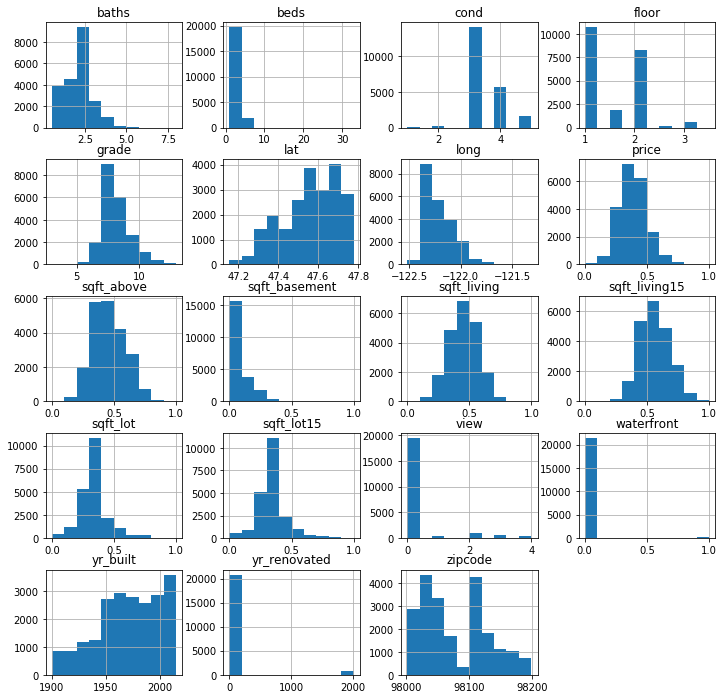

In [20]:
dfscaled.hist(figsize=[12,12]);

In [21]:
formula2 = 'price ~ waterfront + view + yr_renovated + yr_built + zipcode + grade + baths + beds + cond + floor + lat + long + sqft_above + sqft_basement + sqft_living + sqft_living15 + sqft_lot + sqft_lot15'

In [22]:
model2 = ols(formula= formula2, data=dfscaled).fit()

In [23]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     4078.
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        01:16:25   Log-Likelihood:                 32133.
No. Observations:               21597   AIC:                        -6.423e+04
Df Residuals:                   21578   BIC:                        -6.408e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.5858      0.814     -3.178      0.001      -4.181      -0.991
waterfront        0.0887      0.005     17.980      0.000       0.079       0.098
view              0.0145      0.001     25.095      0.000       0.013       0.016
yr_renovated   7.779e-06   1.08e-06      7.194      0.000    5.66e-06     9.9e-06
yr_built         -0.0008   1.95e-05    -42.055      0.000      -0.001      -0.001
zipcode          -0.0001   8.99e-06    -14.632      0.000      -0.000      -0.000
grade             0.0361      0.001     63.663      0.000       0.035       0.037
baths             0.0145      0.001     16.449      0.000       0.013       0.016
beds             -0.0056      0.001    -10.528      0.000      -0.007      -0.005
cond              0.0128      0.001     20.084      0.000       0.012       0.014
floor             0.0108      0.001     10.081      0.000       0.009       0.013
lat               0.2996      0.003    102.115      0.000       0.294       0.305
long             -0.0222      0.004     -6.111      0.000      -0.029      -0.015
sqft_above        0.0718      0.014      5.184      0.000       0.045       0.099
sqft_basement     0.0514      0.011      4.770      0.000       0.030       0.073
sqft_living       0.1819      0.017     10.867      0.000       0.149       0.215
sqft_living15     0.1270      0.005     24.004      0.000       0.117       0.137
sqft_lot          0.0271      0.009      3.084      0.002       0.010       0.044
sqft_lot15       -0.0678      0.009     -7.975      0.000      -0.085      -0.051
==============================================================================
Omnibus:                      385.159   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              720.386
Skew:                           0.109   Prob(JB):                    3.72e-157
Kurtosis:                       3.868   Cond. No.                     2.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

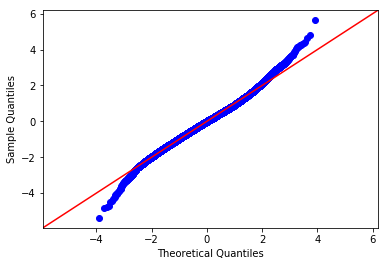

In [24]:
fig = sm.graphics.qqplot(model2.resid, dist=stats.norm, line='45', fit=True)

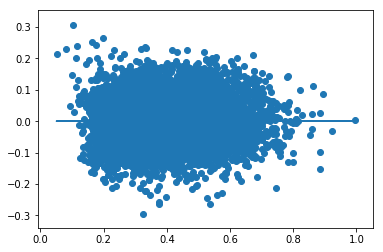

In [27]:
plt.scatter(model2.predict(dfscaled), model2.resid)
plt.plot(model2.predict(dfscaled), [0 for i in range(len(df))])